This notebook contains code for the implementation of VGG-16 architecture from the paper 'Image Based Tomato Leaf Disease Detection' based on the network information and values provided by the authors in the paper.

The VGG-16 architecture is used as a baseline model in my thesis, 'A computer vision approach for the automatic blight disease detection in potato and tomato plants'.

In [1]:
!pip install torchsummary

In [90]:
import os                                      # for working with files
import sys
import shap                                    # for checking feature importances
import torch                                   # Pytorch module 
import shutil
import optuna
import warnings
import numpy as np                             # for numerical computationss
import pandas as pd                            # for working with dataframes
import torch.nn as nn                          # for creating  neural networks
from PIL import Image                          # for checking images
import seaborn as sns
import matplotlib.pyplot as plt                # for plotting informations on graph and images using tensors
import torch.nn.functional as F                # for functions for calculating loss
from torchsummary import summary               # for getting the summary of our model
from torchvision.utils import make_grid        # for data checking
from torch.utils.data import DataLoader        # for dataloaders 
import torchvision.transforms as transforms    # for transforming images into tensors 
from torchvision.datasets import ImageFolder   # for working with classes and images
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


%matplotlib inline

### Data exploration!

In [3]:
os.listdir('/kaggle/input/pt-leaf-data/idata/Image Dataset/ImageDataset/')

['valid', 'train']

In [4]:
data_dir = '/kaggle/input/pt-leaf-data/idata/Image Dataset/ImageDataset/'

In [5]:
# print(f"Number of image directories are {len(os.listdir(data_fpath))+len(os.listdir('/kaggle/input/newds/ImageDataset_new/ImageDataset_new/'))}\n")
print('Number of unique plants are 2, potato and tomato\n')
print('Number of diseases are 4, early and late blight disease for tomato, early and late blight for potato\n')

Number of unique plants are 2, potato and tomato

Number of diseases are 4, early and late blight disease for tomato, early and late blight for potato



In [6]:
data_dir

'/kaggle/input/pt-leaf-data/idata/Image Dataset/ImageDataset/'

In [7]:
train_dir = data_dir + "train/"
valid_dir = data_dir + "valid/"
# test_dir
diseases_tr = os.listdir(train_dir)
diseases_va = os.listdir(valid_dir)


In [8]:
valid_dir

'/kaggle/input/pt-leaf-data/idata/Image Dataset/ImageDataset/valid/'

In [9]:
diseases_tr

['late_blight', 'early_blight', 'healthy']

In [10]:
diseases = []
NumberOfDiseases = 0

for disease in diseases_tr:
    if disease != 'healthy':
        diseases.append(disease)
        NumberOfDiseases += 1
        
diseases

['late_blight', 'early_blight']

In [11]:
# Number of images for each clas in the training data
nums_train = {}
for folder in sorted(os.listdir(f"{data_dir}/train")):
    nums_train[folder] = len(os.listdir(f"/{data_dir}/train/{folder}"))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_training_class = pd.DataFrame(nums_train.values(), index=nums_train.keys(), columns=["no. of images"])
img_per_training_class

,no. of images
early_blight,3996
healthy,4011
late_blight,4002


In [12]:
# Number of images for each clas in the training data
nums_valid = {}
for folder in sorted(os.listdir(f"{data_dir}/valid")):
    nums_valid[folder] = len(os.listdir(f"{data_dir}/valid/{folder}"))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_valid_class = pd.DataFrame(nums_valid.values(), index=nums_valid.keys(), columns=["no. of images"])
img_per_valid_class

,no. of images
early_blight,442
healthy,443
late_blight,446


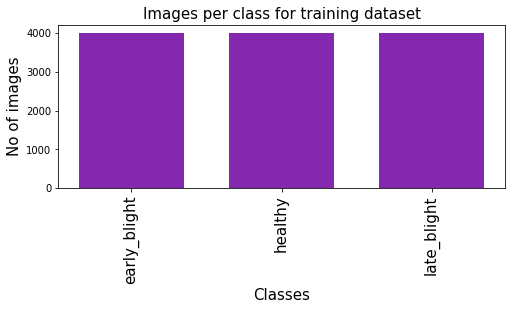

In [14]:
# plotting number of images available for each class
index = [n for n in range(3)]
plt.figure(figsize=(8, 3))
plt.bar(index, [n for n in nums_train.values()], color='#8528B0', width=0.7, align='center')
plt.xlabel('Classes', fontsize=15)
plt.ylabel('No of images', fontsize=15)
plt.xticks(index, [key for key in nums_train.keys()], fontsize=15, rotation=90)
plt.title('Images per class for training dataset', fontsize=15)

#plt.savefig('/kaggle/working/number_imgs_training.png', dpi=600, bbox_inches="tight")  
plt.show()

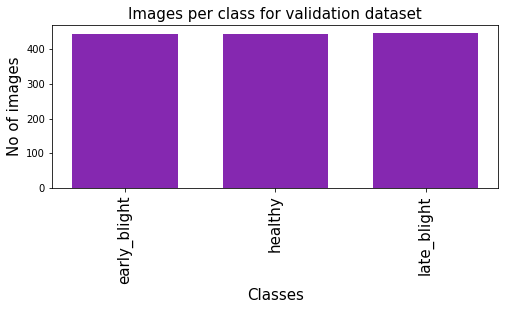

In [15]:
# plotting number of images available for each class
index = [n for n in range(3)]
plt.figure(figsize=(8, 3))
plt.bar(index, [n for n in nums_valid.values()], color='#8528B0', width=0.7) 
plt.xlabel('Classes', fontsize=15)
plt.ylabel('No of images', fontsize=15)
plt.xticks(index, [key for key in nums_valid.keys()], fontsize=15, rotation=90)
plt.title('Images per class for validation dataset', fontsize=15)
# plt.tight_layout()
#plt.savefig('/kaggle/working/number_imgs_validation.png', dpi=600, bbox_inches="tight")  
plt.show()

### Data Augmentation

The data has already been augmented. see https://github.com/Alyeko/potato-tomato-blight-disease-detection

### Images available for training

In [16]:
n_train = 0
for value in nums_train.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 12009 images for training


In [17]:
n_valid = 0
for value in nums_valid.values():
    n_valid += value
print(f"There are {n_valid} images for validation")

There are 1331 images for validation


### Checking if here are non img files in the training data folder


In [18]:
folds = [folder for folder in os.listdir(train_dir)]
folds

['late_blight', 'early_blight', 'healthy']

In [19]:
for i in folds:
    for img in os.listdir(train_dir+i):
        if not img.endswith('.JPG'):
            print('yes!')

In [20]:
for i in folds:
    for img in os.listdir(valid_dir+i):
        if not img.endswith('.JPG'):
            print('yes!')

In [21]:
data_dir

'/kaggle/input/pt-leaf-data/idata/Image Dataset/ImageDataset/'

In [23]:
print(f"There are {len(os.listdir('/kaggle/input/pt-leaf-data/idata/Image Dataset/test_data/test'))} images for test")

There are 1332 images for test


In [24]:
print(f"Training dir: {os.listdir('/kaggle/input/pt-leaf-data/idata/Image Dataset/ImageDataset/')}")
print(f"All: {os.listdir('/kaggle/input/pt-leaf-data/idata/Image Dataset')}")

Training dir: ['valid', 'train']
All: ['test_data', 'ImageDataset']


In [25]:
test_dir = '/kaggle/input/pt-leaf-data/idata/Image Dataset/test_data/'
# print(f"There are {len(os.listdir('/kaggle/input/newds/ImageDataset_new/ImageDataset_new/test_data'))} images for training")
os.listdir(test_dir)

['test']

In [26]:
for img in os.listdir(test_dir+'test'):
        if not img.endswith('.JPG'):
            print('Yes! I knew it!')

Yes! I knew it!


### Data Preparation for training 

In [27]:
print(train_dir)
print(valid_dir)

/kaggle/input/pt-leaf-data/idata/Image Dataset/ImageDataset/train/
/kaggle/input/pt-leaf-data/idata/Image Dataset/ImageDataset/valid/


In [28]:
# datasets for validation and training
train = ImageFolder(train_dir, transform=transforms.Compose(
                                        [transforms.Resize([224, 224]), #VGG-16 requires input images to be 224x224
                                         transforms.ToTensor()]))

valid = ImageFolder(valid_dir, transform=transforms.Compose(
                                        [transforms.Resize([224, 224]),
                                         transforms.ToTensor()]))

In [29]:
#Image shape
img, label = train[4590]
print(img.shape, label)

img, label = train[0]
print(img.shape, label)

torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 0


We can see the shape (3, 224, 224) of the image. 3 is the number of channels (RGB) and 224 x 224 is the width and height of the image

In [30]:
len(train.classes) #multiclass classification with 6 classes

3

In [32]:
# for checking some images from training dataset
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

In [33]:
# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)

Label :late_blight(2)


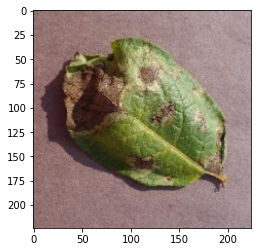

In [34]:
show_image(*train[10000])

Label :healthy(1)


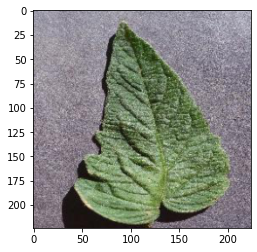

In [35]:
show_image(*train[6580])

Label :early_blight(0)


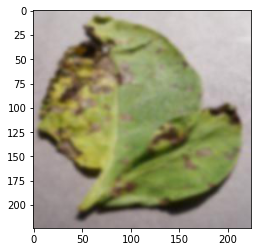

In [36]:
show_image(*train[1000])

Label :healthy(1)


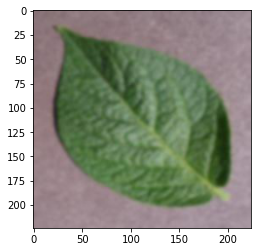

In [37]:
show_image(*train[5000])

In [38]:
print(train, '\n')
print(valid)

Dataset ImageFolder
    Number of datapoints: 12009
    Root location: /kaggle/input/pt-leaf-data/idata/Image Dataset/ImageDataset/train/
    StandardTransform
Transform: Compose(
               Resize(size=[224, 224], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           ) 

Dataset ImageFolder
    Number of datapoints: 1331
    Root location: /kaggle/input/pt-leaf-data/idata/Image Dataset/ImageDataset/valid/
    StandardTransform
Transform: Compose(
               Resize(size=[224, 224], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [39]:
# DataLoaders for training and validation
# setting the batch size
batch_size = 32
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

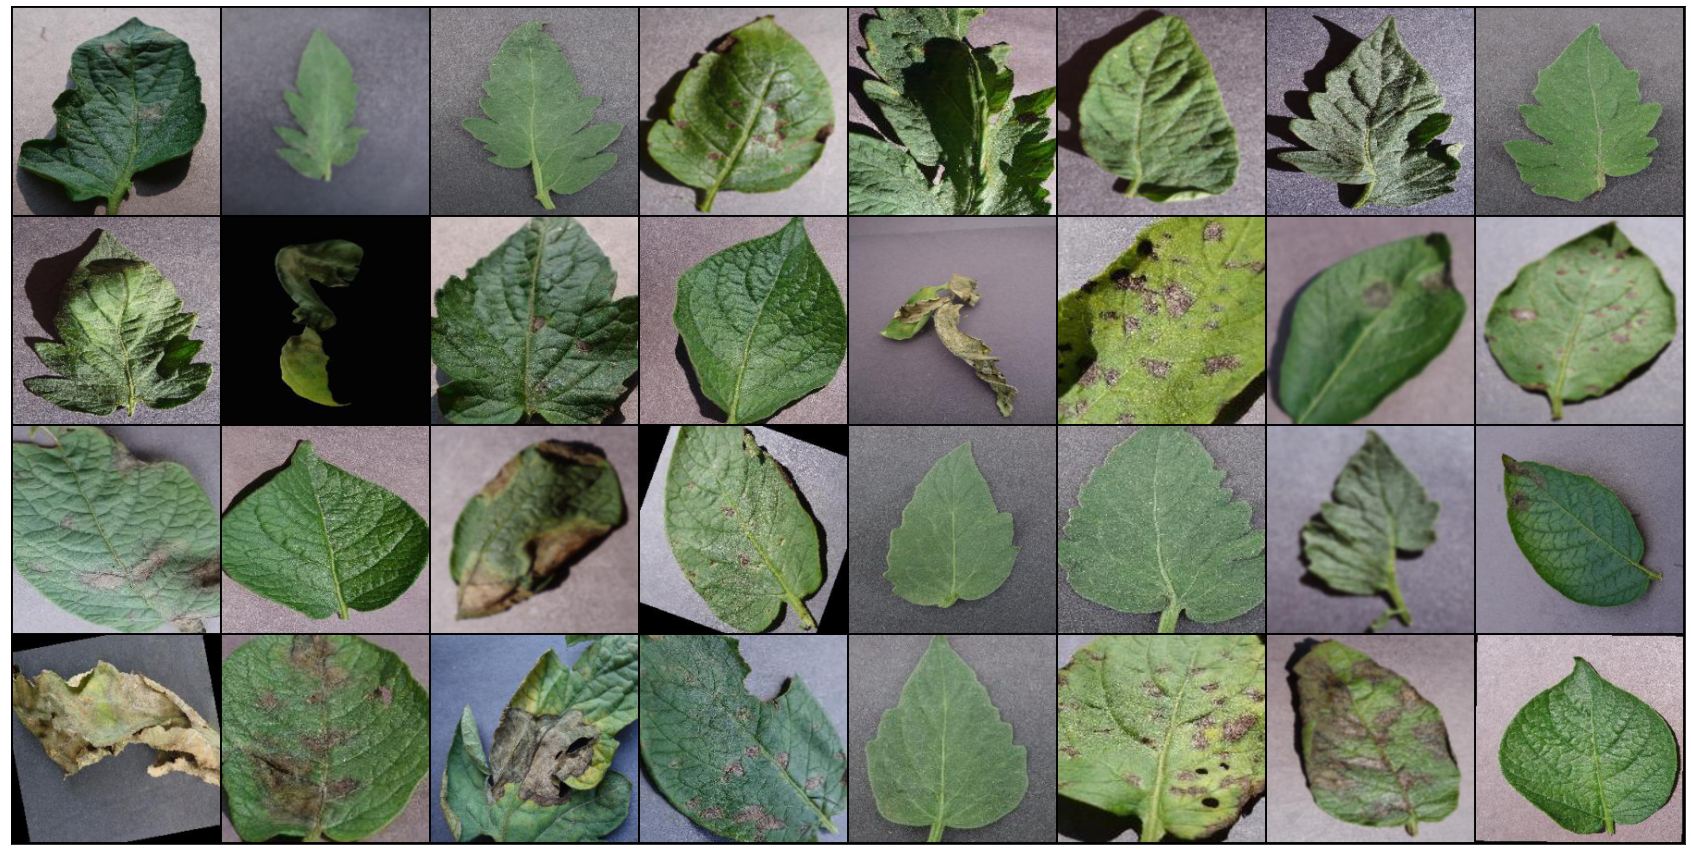

In [40]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break
        
# Images for first batch of training
show_batch(train_dl) 

In [41]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [42]:
device = get_default_device()
device

device(type='cuda')

In [43]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [44]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        train_acc = accuracy(out, labels)
        return loss
    
    def training_step_4_acc(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        train_acc = accuracy(out, labels)
        return train_acc
        
        
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['train_accuracy'], result['val_loss'], result['val_accuracy']))
        

In [45]:
# Architecture for training

# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


class VGG16(ImageClassificationBase):
    def __init__(self, num_classes):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(25088, 4096),  #or 25088, #(32x32768 and 25088x4096)
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [46]:
# defining the model and moving it to the GPU
model = to_device(VGG16(3), device) 
model

VGG16(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

# getting summary of the model
INPUT_SHAPE = (3, 224, 224)
print(summary(model.cuda(), (INPUT_SHAPE)))

In [48]:
# for training, added my code
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, momentum=0, weight_decay=0,
                 grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay, momentum)
         
    
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        train_accuracies = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            t_acc = model.training_step_4_acc(batch)
            train_losses.append(loss)
            train_accuracies.append(t_acc)
            loss.backward()
            
            
            # gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
            
    
        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.stack(train_accuracies).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history
    

%%time
history = [evaluate(model, valid_dl)]
history

------------------------

In [49]:
epochs = 30  #THESE ARE THE PARAMETERS FROM THE PAPAER...
max_lr =0.0005
grad_clip = 0.1
weight_decay = 0.0005
opt_func = torch.optim.SGD

history = fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=0.1, momentum=0.9,
                             weight_decay=0.0005, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00003, train_loss: 1.0919, train_accuracy: 0.3586, val_loss: 1.0512, val_acc: 0.5475
Epoch [1], last_lr: 0.00008, train_loss: 1.0611, train_accuracy: 0.4374, val_loss: 0.9658, val_acc: 0.6827
Epoch [2], last_lr: 0.00014, train_loss: 0.9865, train_accuracy: 0.5386, val_loss: 0.8004, val_acc: 0.7648
Epoch [3], last_lr: 0.00022, train_loss: 0.8291, train_accuracy: 0.6502, val_loss: 0.5794, val_acc: 0.7867
Epoch [4], last_lr: 0.00030, train_loss: 0.6460, train_accuracy: 0.7331, val_loss: 0.4872, val_acc: 0.7961
Epoch [5], last_lr: 0.00038, train_loss: 0.5113, train_accuracy: 0.7995, val_loss: 0.3407, val_acc: 0.8636
Epoch [6], last_lr: 0.00044, train_loss: 0.4082, train_accuracy: 0.8460, val_loss: 0.3156, val_acc: 0.8717
Epoch [7], last_lr: 0.00049, train_loss: 0.3203, train_accuracy: 0.8831, val_loss: 0.2307, val_acc: 0.9129
Epoch [8], last_lr: 0.00050, train_loss: 0.2493, train_accuracy: 0.9104, val_loss: 0.1809, val_acc: 0.9310
Epoch [9], last_lr: 0.00050, train_lo

In [50]:
def plot_accuracies(history):
    val_accuracies = [x['val_accuracy'] for x in history[1:]]
    train_accuracies = [x['train_accuracy'] for x in history[1:]]
    plt.grid(color='#EAE4E3')
    plt.plot(train_accuracies, '-o', color='blue', label='Training')
    plt.plot(val_accuracies, '-o', color='green', label = 'Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracies')
    plt.legend()
    plt.title('Training and Validation accuracies of VGG-16');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history[1:]]
    val_losses = [x.get('val_loss').cpu().numpy() for x in history[1:]] #[x['val_loss'] for x in history]
    plt.grid(color='#EAE4E3')
    plt.plot(train_losses, '-bo', label='Training')
    plt.plot(val_losses, '-go', label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.legend()#['Training', 'Validation'])
    plt.title('Training and Validation losses of VGG-16');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.grid(color='#EAE4E3')
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

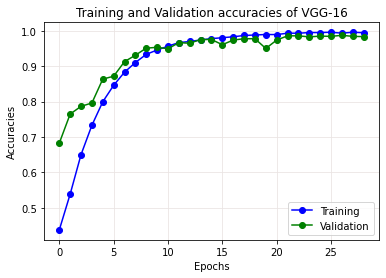

In [51]:
#Validation accuracy
plot_accuracies(history)

plt.rcParams['figure.figsize'] = [8, 8]
epochs = [i for i in range(1, 31)]
val_accuracies = [x['val_accuracy'] for x in history]
train_accuracies = [x['train_accuracy'] for x in history]
plt.plot(epochs, train_accuracies, '-o', color='blue', label='train_loss')
plt.plot(epochs, val_accuracies, '-o', color='green', label='validation_loss')
plt.xticks(np.arange(min(epochs), max(epochs)+1, 1.0))
plt.xlabel('Epochs', size=13)
plt.ylabel('Accuracies', size=13)
plt.grid(color='#EAE4E3')
#plt.xticks(rotation=90)
plt.title('Training and validation accuracies of VGG-16', size=13)
plt.legend()
plt.savefig('../working/VGG16-tv-accuracies.png', dpi=600,  bbox_inches="tight")
plt.show()

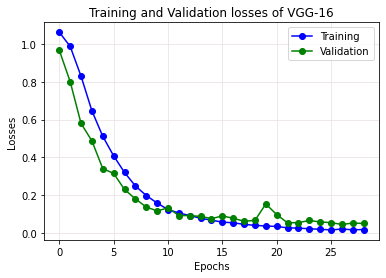

In [52]:
#Validation loss
plot_losses(history)

plt.rcParams['figure.figsize'] = [8, 8]
epochs = [i for i in range(1, 31)]
train_losses = [x.get('train_loss') for x in history]
val_losses = [x.get('val_loss').cpu().numpy() for x in history]
plt.plot(epochs, train_losses, '-o', color='blue', label='train_loss')
plt.plot(epochs, val_losses, '-o', color='green', label='validation_loss')
plt.xticks(np.arange(min(epochs), max(epochs)+1, 1.0))
plt.xlabel('Epochs', size=13)
plt.ylabel('Losses', size=13)
plt.grid(color='#EAE4E3')
plt.xticks(rotation=90)
plt.title('Training and validation losses of VGG-16', size=13)
plt.legend()
plt.savefig('../working/VGG16-tv-losses.png', dpi=600,  bbox_inches="tight")
plt.show()

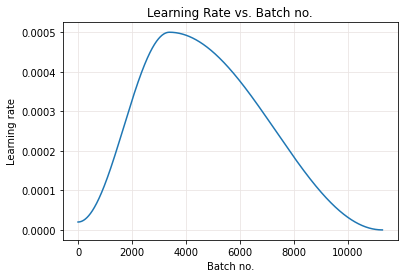

In [53]:
#Learning Rate overtime
plot_lrs(history)

In [ ]:
# os.listdir('../input/imagedataset/ImageDataset/test_data')
# os.listdir('../test')

In [54]:
###Creating a new test dir because there was an svn file or folder found in the test dir
os.mkdir('../test_data')
os.mkdir('../test_data/test')

In [55]:
test_dir_old = test_dir
test_dir_new = '../test_data'
print(test_dir_old)
print(test_dir_new)

/kaggle/input/pt-leaf-data/idata/Image Dataset/test_data/
../test_data


In [56]:
test_dir_old

'/kaggle/input/pt-leaf-data/idata/Image Dataset/test_data/'

In [57]:
for f in os.listdir(f'{test_dir_new}/test'):
    os.remove(f'{test_dir_new}/test/{f}')

In [58]:
os.listdir(f'{test_dir_new}/test')

[]

In [60]:
for theclass in train.classes:
#     print(f"{test_dir_new}/test/{theclass}")
    os.mkdir(f"{test_dir_new}/test/{theclass}")

In [61]:
os.listdir(f'{test_dir_new}/test')

['healthy', 'early_blight', 'late_blight']

In [62]:
###Moving file from old test dir to new test dir
num_moved = 0
for img in os.listdir(test_dir_old+'/test'):
    if img.endswith('.JPG'):
        if img.split('_')[1] !='healthy':
            theclass = img.split('_')[1] + '_blight'
            #print(theclass)
            shutil.copy(f"{test_dir_old+'/test/'}{img}", f"{test_dir_new+'/test/'+theclass+'/'+img}")
        
        elif img.split('_')[1] =='healthy':
            theclass = img.split('_')[1] 
            #print(theclass)
            shutil.copy(f"{test_dir_old+'/test/'}{img}", f"{test_dir_new+'/test/'+theclass+'/'+img}")
        
        num_moved += 1
    elif img.endswith('svn'):
        print('not going to move you!')
print(f"Number of files moved: {num_moved}")

not going to move you!
Number of files moved: 1331


In [63]:
len(os.listdir(f'{test_dir_new}/test')) #3 folders which are early_blight, healthy and late_blight

3

In [64]:
len(os.listdir('../test_data/test')) #files have been moved

3

In [65]:
os.listdir(f"{test_dir_new}")

['test']

In [66]:
#Testing model on test data
test = ImageFolder('../test_data/test', transform=transforms.Compose(
                                        [transforms.Resize([224, 224]),
                                         transforms.ToTensor()]))

In [67]:
test

Dataset ImageFolder
    Number of datapoints: 1331
    Root location: ../test_data/test
    StandardTransform
Transform: Compose(
               Resize(size=[224, 224], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [69]:
os.listdir(test_dir_new + '/test')

['healthy', 'early_blight', 'late_blight']

In [79]:
os.listdir(test_dir_new + '/test')

['healthy', 'early_blight', 'late_blight']

In [80]:
early = os.listdir(test_dir_new + '/test/healthy')
healthy = os.listdir(test_dir_new + '/test/early_blight')
late = os.listdir(test_dir_new + '/test/late_blight')

test_images = sorted(early+healthy+late) # since images in test folder are not in alphabetical order
print(len(test_images))

1331


In [81]:
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label

    return train.classes[preds[0].item()]

In [82]:
len(test)

1331

In [83]:
img, label = test[-1]
label

2

In [84]:
print(len(test_images))
print(len(test))

1331
1331


Label: tomato_late_87.JPG , Predicted: late_blight


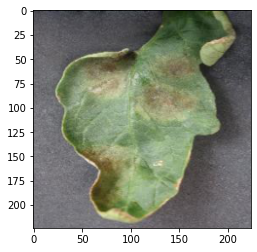

In [89]:
# predicting first image
img, label = test[-11]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[-11], ', Predicted:', predict_image(img, model))

In [91]:
type(test)

torchvision.datasets.folder.ImageFolder

In [92]:
test_loader_r = torch.utils.data.DataLoader(test, 
                                            batch_size=batch_size,
                                            shuffle=True)

test_loader_r = DeviceDataLoader(test_loader_r, device)
test_loader_r

In [93]:
predictions =[] #code adapted from https://stackoverflow.com/questions/63647547/how-to-find-confusion-matrix-and-plot-it-for-image-classifier-in-pytorch
targets = []
for images, labels in test_loader_r:
    images, labels = images.cuda(), labels.cuda()
    logps = model(images)
    output = torch.exp(logps)
    pred = torch.argmax(output, 1)

    # convert to numpy arrays
    pred = pred.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    
    for i in range(len(pred)):
        predictions.append(pred[i])
        targets.append(labels[i])

In [94]:
train.classes

['early_blight', 'healthy', 'late_blight']

In [95]:
targets[:5]

[0, 2, 1, 2, 2]

In [96]:
predictions[:5]

[0, 2, 1, 2, 2]

In [97]:
cf_matrix = confusion_matrix(targets, predictions)
cf_matrix

array([[438,   0,   4],
       [  0, 249,   1],
       [ 10,   2, 627]])

In [98]:
class_names = train.classes
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)
dataframe

,early_blight,healthy,late_blight
early_blight,438,0,4
healthy,0,249,1
late_blight,10,2,627


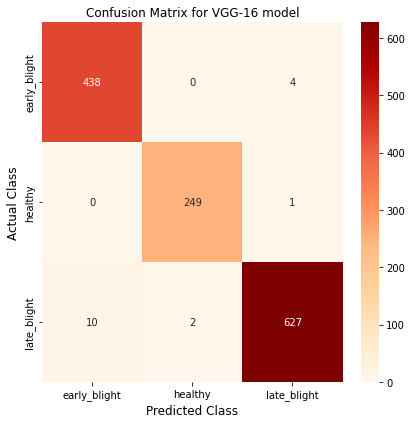

In [99]:
plt.figure(figsize=(6, 6))  #change size to 4, 4?

#Create heatmap
sns.heatmap(dataframe, annot=True, cbar=True,cmap="OrRd",fmt="d") #'purples', 'PuRd'
plt.title("Confusion Matrix for VGG-16 model", size=12), plt.tight_layout()
 
plt.ylabel("Actual Class", size=12), 
plt.xlabel("Predicted Class",  size=12)
plt.tight_layout()
plt.savefig('../working/cmatrxvgg16.png', dpi=600,  bbox_inches="tight")
plt.show()

In [100]:
print("Test Accuracy : {}".format(accuracy_score(targets, predictions)))
print("\nConfusion Matrix : ")
print(confusion_matrix(targets, predictions))
print("\nClassification Report :")
print(classification_report(targets, predictions, target_names=train.classes))

Test Accuracy : 0.9872276483846731

Confusion Matrix : 
[[438   0   4]
 [  0 249   1]
 [ 10   2 627]]

Classification Report :
              precision    recall  f1-score   support

early_blight       0.98      0.99      0.98       442
     healthy       0.99      1.00      0.99       250
 late_blight       0.99      0.98      0.99       639

    accuracy                           0.99      1331
   macro avg       0.99      0.99      0.99      1331
weighted avg       0.99      0.99      0.99      1331

